In [ ]:
%%capture
!pip install adtk

# Anomaly Detection and Labelling in OCHLV Data

### Implementing Recommendations from Advances

Here we implement examples from Advances by Lopez de Prado particularly Chapter 3 recommendation surrounding boxes and the CUSUM filter and use ADTK visualization for pretty diagrams.

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,11.04,10.78,10.82,10.85,34412700,10.85
2010-01-05,11.29,10.63,10.86,11.17,60659000,11.17
2010-01-06,11.34,10.99,11.08,11.22,32060400,11.22
2010-01-07,11.25,10.56,11.23,10.84,46461800,10.84
2010-01-08,11.17,10.62,10.75,11.10,32433400,11.10


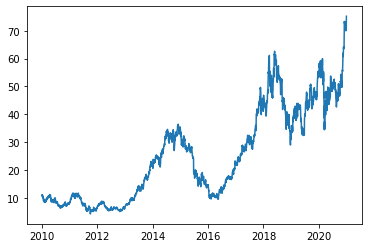

In [ ]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from adtk.visualization import plot

# Load some simple OCHLV data to play with:

ochlv = pdr.get_data_yahoo("MU","2010-1-1","2021-1-1")

plt.plot(ochlv['Close'])
ochlv.head()

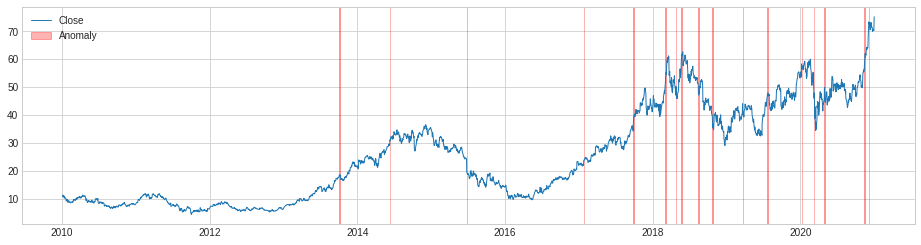

In [ ]:
import pandas as pd
import numpy as np

# The Symmetric CUSUM Filter lifted from Advances

def getTEvents(gRaw,h):
  tEvents,sPos,sNeg = [],0,0
  diff = gRaw.diff()
  for i in diff.index[1:]:
    sPos,sNeg = max(0,sPos+diff.loc[i]),min(0,sNeg+diff.loc[i])
    if sNeg<-h:
      sNeg = 0;tEvents.append(i)
    elif sPos>h:
      sPos = 0;tEvents.append(i)
  return pd.DatetimeIndex(tEvents)

# Function to get anomalie indices to plotable indice array

def index2anomaly(anomalies):
  anomalies = anomalies.to_series().asfreq("D")
  anomalies.loc[~pd.isnull(anomalies)] = 1.0
  anomalies.loc[pd.isnull(anomalies)] = 0.0

  return anomalies

anomalies = getTEvents(ochlv['Close'],14)
anomalies = index2anomaly(anomalies)

# Recreate the graph seen in Advances

plot(ochlv['Close'], anomaly=anomalies, ts_linewidth=1, ts_markersize=0, anomaly_color='red');

We now implement the boxes method described in Advances too.

In [ ]:
# Implement preliminary price-scaled boxes.

A few applications of the `ADTK` library, particularly their in-built `detector` module and a demonstration of how to use in-build transformers to construct `CustomDetectors1d`.

Feel free to play around with parameters in the below examples relevant to a 1D time series.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


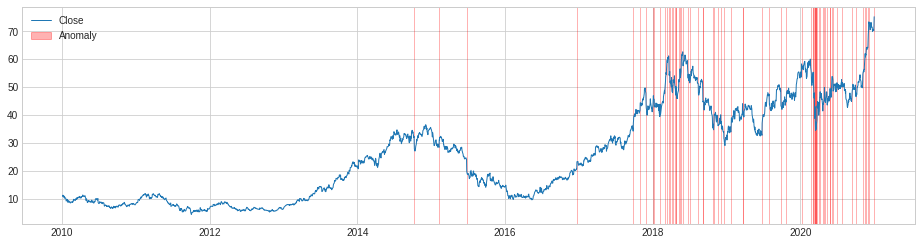

In [ ]:
from adtk.detector import PersistAD

persist_ad = PersistAD(c=3.0)
anomalies = persist_ad.fit_detect(ochlv['Close'])
plot(ochlv['Close'], anomaly=anomalies, ts_linewidth=1, ts_markersize=0, anomaly_color='red');

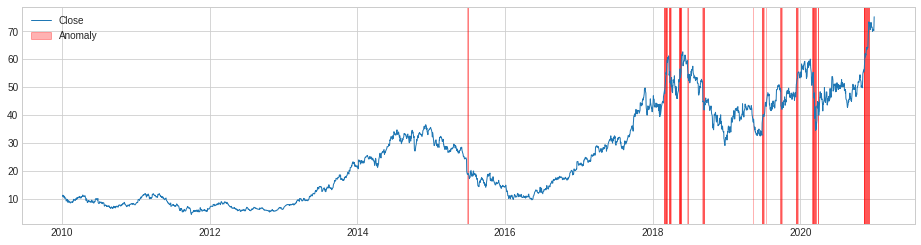

In [ ]:
from adtk.detector import LevelShiftAD

level_ad = LevelShiftAD(10,c=2.5)
anomalies = level_ad.fit_detect(ochlv['Close'])
plot(ochlv['Close'],anomaly=anomalies,ts_linewidth=1, ts_markersize=0, anomaly_color='red')

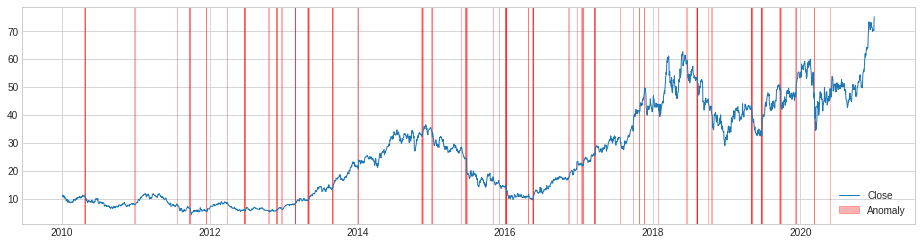

In [ ]:
from adtk.detector import VolatilityShiftAD

vol_ad = VolatilityShiftAD(c=2.5, side='both', window=10)
anomalies = vol_ad.fit_detect(ochlv['Close'])
plot(ochlv['Close'],anomaly=anomalies,ts_linewidth=1,ts_markersize=0,anomaly_color='red')

### Designing Customized Detectors

We will use a `DoubleRollingAggregator` which computes some statistical estimator (eg. mean, variance, etc.) over two sliding windows with different intervals and then computes a metric distance (eg. L1, difference, etc.) between the two.

This *transforms* the original time series into a "derivative" of some statistical property of rolling windows on the time series. Under this rationale, large peaks and troughs then correspond to large changes of the statistical properties of a given times series. We can then detect these large changes with a threshold, a geometric peak detection method or with more calculus.

Below we will implement such a detector which can pick up large changes in skew, mathematical motivations for this is if we assume the "local" picture of a stock is a Geometric Brownian Motion with fixed parameters, then we can expect a window's estimators from fixed point to be approximately log-normal (as these are computed from sums of log-normal samples).

A shift in this local picture would cause a shift in the transition log-normal distribution, along with its skew (with very high skew implying the stock is crashing, and low skew implying a stable regime). So a negative "derivative" of skew implies a transition to a more stable regime and positive "derivative" of skew implies a transition to a crash.

It is important to remember that to apply a Geometric Brownian Motion that returns must be normally distributed - this is not necessarily the case with time bars (as noted in Advances).

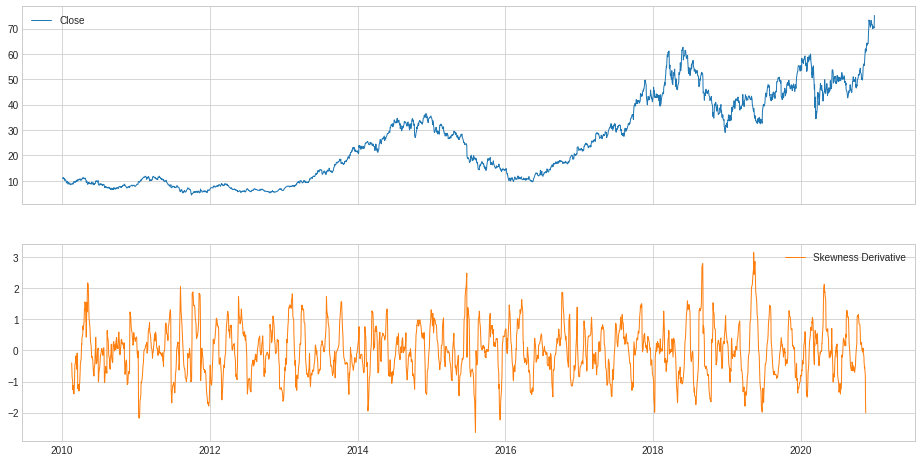

In [ ]:
from adtk.data import validate_series

# Load in close data, validate_series is just a data cleaning function for ADTK
s = ochlv['Close']
s = validate_series(s)

from adtk.transformer import DoubleRollingAggregate

# Transform the data

s_transformed = DoubleRollingAggregate(
    agg="skew",
    window=30,
    diff="diff").transform(s).rename("Skewness Derivative")


plot(pd.concat([s, s_transformed], axis=1),ts_linewidth=1,ts_markersize=0);

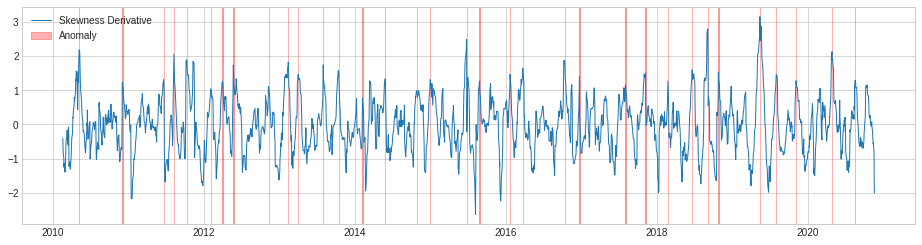

In [ ]:
# Find peaks and troughs:

import scipy.signal as sgn

anomalies = sgn.find_peaks(s_transformed, prominence=2)[0]
#anomalies = np.concatenate((anomalies,sgn.find_peaks(-s_transformed, prominence=1)[0]))
anomalies = s_transformed.iloc[anomalies].index
anomalies = index2anomaly(anomalies)

# Plot skewness derivative with anomalies

plot(s_transformed, anomaly=anomalies, ts_linewidth=1, ts_markersize=0,anomaly_color='red')

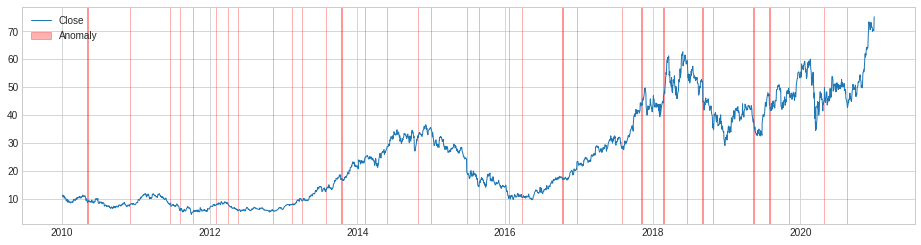

In [ ]:
# Plot this on price

plot(ochlv['Close'], anomaly = anomalies, ts_linewidth=1, ts_markersize=0, anomaly_color='red')

We now investigate the use of `DeepADoTS` supervised anomaly detection 

1.   List item
2.   List item

framework. Quick colab setup: